# Machine learning modelling for 'koopPrijs'

### Introduction

This project is executed for the course of AI for Business, at the Amsterdam School of Applied Sciences in 2022. The purpose of the research is to to build and evaluate machine learning approaches to predict the price of a  house and the time to sale of a house. The dataset that is used to train and evaluate the models is scraped from the Dutch housing website Funda. In this notebook, two machine learning models will be tested and compared with each other to see what model predict the best result. The project is conducted and combined by Pim Doosje (500800438) and Joel Zelle (500763451).


### Importing the dataset and libraries

In [1]:
# importing all libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import scikeras
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime

In [2]:
# showing all outputs in this notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# importing prepared csv file
df_cleaned = pd.read_csv('prepared_df2.csv')

### Checking and final preparation of the data

In [4]:
# showing the header of the cleaned csv header
df_cleaned.head()

,Unnamed: 0.1,Unnamed: 0,main_topic,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,soortWoning_cleaned,postcode_prepared
0,0,0,Topic 10,139000.0,1971,1,3,62,104,vrijstaande_woning,0
1,2,2,Topic 2,267500.0,2001,0,3,70,113,appartement,1
2,3,3,Topic 3,349000.0,1973,1,5,144,132,eengezinswoning,2
3,4,4,Topic 6,495000.0,1900,0,8,323,123,vrijstaande_woning,3
4,5,5,Topic 9,162500.0,1970,1,4,68,243,eengezinswoning,4


In [5]:
# showing all data types and making sure that all of them are integers or float except the soortwoning which still has to be dummified
df_cleaned.dtypes

Unnamed: 0.1             int64
Unnamed: 0               int64
main_topic              object
koopPrijs              float64
bouwjaar                 int64
indTuin                  int64
aantalKamers             int64
oppervlakte              int64
Time_to_sell             int64
soortWoning_cleaned     object
postcode_prepared        int64
dtype: object

In [6]:
# checking for null values
df_cleaned.isnull().sum()

Unnamed: 0.1           0
Unnamed: 0             0
main_topic             0
koopPrijs              0
bouwjaar               0
indTuin                0
aantalKamers           0
oppervlakte            0
Time_to_sell           0
soortWoning_cleaned    0
postcode_prepared      0
dtype: int64

In [7]:
# drop 1 Unnamed column
df_cleaned = df_cleaned.drop('Unnamed: 0.1', axis= 1)

In [8]:
# the last transformation to make the data set ready for modelling
df= df_cleaned
columns = ['koopPrijs', 'bouwjaar']
for col in columns:
    df[col] = df[col].astype('int64')

In [9]:
# Renaming df and renaming column
df = df_cleaned.rename(columns={'Unnamed: 0': 'id'})

In [10]:
# Final check to see if the dataframe is correct
df.head()

,id,main_topic,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,soortWoning_cleaned,postcode_prepared
0,0,Topic 10,139000,1971,1,3,62,104,vrijstaande_woning,0
1,2,Topic 2,267500,2001,0,3,70,113,appartement,1
2,3,Topic 3,349000,1973,1,5,144,132,eengezinswoning,2
3,4,Topic 6,495000,1900,0,8,323,123,vrijstaande_woning,3
4,5,Topic 9,162500,1970,1,4,68,243,eengezinswoning,4


### Splitting the data

In [11]:
# defining the splitter to split the data set between training, testing and validation sets
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        print("split completed")

In [12]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()
fitting_splits.split_train_test(df)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [13]:
# checking if they're devided correctly
fitting_splits.train_set.shape
fitting_splits.test_set.shape
fitting_splits.validation_set.shape

(130027, 10)

(40633, 10)

(32507, 10)

### Data preparation for the models: dummifying and scaling

In [14]:
# dummify the soortWoning column, in the training set: from catagory to integer 
# this needs to be done, so the outcomes become numbers. Only numbers can be used in creating the model.
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(fitting_splits.train_set[['soortWoning_cleaned', 'main_topic']])

OneHotEncoder()

In [15]:
# apply the encoder
one_hot_encoder.categories_ 
encoded_names = one_hot_encoder.get_feature_names_out() 
encoded_names

encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['soortWoning_cleaned', 'main_topic']]).toarray() 
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['appartement', 'benedenwoning', 'bovenwoning', 'eengezinswoning',
        'herenhuis', 'other', 'portiekflat', 'vrijstaande_woning'],
       dtype=object),
 array(['Topic 1', 'Topic 10', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5',
        'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9'], dtype=object)]

array(['soortWoning_cleaned_appartement',
       'soortWoning_cleaned_benedenwoning',
       'soortWoning_cleaned_bovenwoning',
       'soortWoning_cleaned_eengezinswoning',
       'soortWoning_cleaned_herenhuis', 'soortWoning_cleaned_other',
       'soortWoning_cleaned_portiekflat',
       'soortWoning_cleaned_vrijstaande_woning', 'main_topic_Topic 1',
       'main_topic_Topic 10', 'main_topic_Topic 2', 'main_topic_Topic 3',
       'main_topic_Topic 4', 'main_topic_Topic 5', 'main_topic_Topic 6',
       'main_topic_Topic 7', 'main_topic_Topic 8', 'main_topic_Topic 9'],
      dtype=object)

,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,soortWoning_cleaned_bovenwoning,soortWoning_cleaned_eengezinswoning,soortWoning_cleaned_herenhuis,soortWoning_cleaned_other,soortWoning_cleaned_portiekflat,soortWoning_cleaned_vrijstaande_woning,main_topic_Topic 1,main_topic_Topic 10,main_topic_Topic 2,main_topic_Topic 3,main_topic_Topic 4,main_topic_Topic 5,main_topic_Topic 6,main_topic_Topic 7,main_topic_Topic 8,main_topic_Topic 9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130022,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130023,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130024,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
130025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# dropping the non dummified soortWoning and topic column, and the adding the dummified array to the training dataset
train_set = fitting_splits.train_set.drop(['soortWoning_cleaned', 'main_topic'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,id,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,postcode_prepared,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,...,main_topic_Topic 1,main_topic_Topic 10,main_topic_Topic 2,main_topic_Topic 3,main_topic_Topic 4,main_topic_Topic 5,main_topic_Topic 6,main_topic_Topic 7,main_topic_Topic 8,main_topic_Topic 9
0,60594,395000,2004,1,6,166,25,58570,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,76397,275000,1980,0,4,121,179,73921,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,209175,297500,1998,1,5,121,8,203331,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70903,279000,1970,1,5,142,27,68627,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,184014,209000,1963,1,5,89,23,178820,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130022,78244,275000,1931,0,4,110,53,75725,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130023,5020,550000,1976,1,5,255,297,4735,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130024,39590,189500,1979,1,6,121,13,38034,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
130025,109599,285000,1927,0,5,123,29,106351,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# applying the scaler
standard_scaler = StandardScaler()
standard_scaler.fit(train_set)

StandardScaler()

In [18]:
class DataPreparer(object):
    def __init__(self, one_hot_encoder, standard_scaler):
        self.one_hot_encoder = one_hot_encoder
        self.standard_scaler = standard_scaler

    def dummify(self, df):
        vars_to_encode = ['soortWoning_cleaned', 'main_topic']
        df_to_encode = df[vars_to_encode]
        df_encoded = self.one_hot_encoder.transform(df_to_encode).toarray()
        df_encoded = pd.DataFrame(df_encoded)
        df_encoded.columns = self.one_hot_encoder.get_feature_names_out()
        # add the encoded columns and drop the original columns
        df = df.drop(vars_to_encode,axis=1)
        df = pd.concat([df, df_encoded], axis=1)
        return df

    def scale(self, df):
        cols = df.columns
        df = self.standard_scaler.transform(df)
        df = pd.DataFrame(df)
        df.columns = cols
        return df

    def prepare_data(self, df):
        df = df.reset_index(drop=True)
        # first dummify the data
        df = self.dummify(df)
        # then scale it
        df = self.scale(df)
        return df

In [19]:
# applying one hot encoder and standard scaler and checking if it went correctly
data_preparer = DataPreparer(one_hot_encoder, standard_scaler)
data_preparer.prepare_data(fitting_splits.train_set).head()
data_preparer.prepare_data(fitting_splits.validation_set).head()

,id,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,postcode_prepared,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,...,main_topic_Topic 1,main_topic_Topic 10,main_topic_Topic 2,main_topic_Topic 3,main_topic_Topic 4,main_topic_Topic 5,main_topic_Topic 6,main_topic_Topic 7,main_topic_Topic 8,main_topic_Topic 9
0,-0.747856,0.372573,0.787243,0.636097,0.855258,0.947826,-0.540371,-0.748392,-0.503394,-0.080394,...,-0.488431,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,3.610083,-0.239845,-0.261929,-0.365320
1,-0.488208,-0.225398,0.159442,-1.572088,-0.424642,0.021825,1.631204,-0.489371,1.986517,-0.080394,...,-0.488431,-0.462323,-0.175984,-0.241133,2.416147,-0.319153,-0.277002,-0.239845,-0.261929,-0.365320
2,1.693373,-0.113278,0.630293,0.636097,0.215308,0.021825,-0.780090,1.694196,-0.503394,-0.080394,...,2.047373,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,-0.261929,-0.365320
3,-0.578476,-0.205466,-0.102142,0.636097,0.215308,0.453959,-0.512168,-0.578698,-0.503394,-0.080394,...,-0.488431,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,3.610083,-0.239845,-0.261929,-0.365320
4,1.279970,-0.554282,-0.285251,0.636097,0.215308,-0.636664,-0.568573,1.280616,-0.503394,-0.080394,...,-0.488431,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,-0.261929,2.737325


,id,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,postcode_prepared,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,...,main_topic_Topic 1,main_topic_Topic 10,main_topic_Topic 2,main_topic_Topic 3,main_topic_Topic 4,main_topic_Topic 5,main_topic_Topic 6,main_topic_Topic 7,main_topic_Topic 8,main_topic_Topic 9
0,-0.808878,-0.349975,0.499501,0.636097,0.215308,0.412803,-0.357056,-0.809929,-0.503394,-0.080394,...,2.047373,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,-0.261929,-0.365320
1,0.002252,-0.424722,0.002491,0.636097,0.215308,0.762626,-0.427561,0.002603,-0.503394,-0.080394,...,2.047373,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,-0.261929,-0.365320
2,-1.591683,3.387345,-0.546835,0.636097,0.215308,2.614626,1.772215,-1.588629,-0.503394,-0.080394,...,-0.488431,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,-0.261929,2.737325
3,-0.287249,1.144953,-2.456398,-1.572088,2.775108,2.264804,-0.469865,-0.288073,-0.503394,-0.080394,...,-0.488431,2.162991,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,-0.261929,-0.365320
4,-0.190886,-0.387349,0.054808,0.636097,0.215308,-0.060486,-0.667281,-0.190984,-0.503394,-0.080394,...,-0.488431,-0.462323,-0.175984,-0.241133,-0.413882,-0.319153,-0.277002,-0.239845,3.817830,-0.365320


In [20]:
# create training sets, without the the target 'koopPrijs' which is going to measure the buying price. The 'id' column is also taken out, as it has no additional value to the model.
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['koopPrijs', 'id'], axis=1) # need to drop the target! otherwise data leakage
y_train = fitting_splits.train_set['koopPrijs'] # take it from the original untransformed dataset

In [21]:
# now we can use the fitted random tree model to predict on the test dataset
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['koopPrijs', 'id'], axis=1)
y_test = fitting_splits.test_set['koopPrijs']

## Random forest model

### Finding the most suitable hyperparameters for the Random Forest model


In [22]:
# overview off all hyperparameters for the Randomforest model
rf = RandomForestRegressor(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [23]:
# creating a grid from the hypertuning parameters
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50], 'n_estimators': [50, 100, 150, 200]}


### Training the Random Forest model


In [24]:
# defining the model
def fit_RF_model(X_train, y_train, n, depth):
    # create the model instance with the required parameters
    simple_RF = RandomForestRegressor(random_state=1234, n_estimators=n, max_depth=depth)
    # fit the model instance on X_train
    simple_RF.fit(X=X_train, y=y_train)
    return simple_RF

 # will hold the models fitted on train, for each hyperparameter combination
fitted_models = []

# train a model for each hyperparameter combination
print("begin hypertuning")
for n in n_estimators:
    for depth in max_depth:
        # fit a model with the given hyperparameter values.
        # A new model will be fitted for each loop cycle
        print(f"fitting model for n_estimators: {n} and max_depth: {depth}")
        fitted_model = fit_RF_model(X_train, y_train, n, depth)
        print(f"fitting complete.")
        # store the fitted model in the fitted_model list
        fitted_models.append(fitted_model)


begin hypertuning
fitting model for n_estimators: 50 and max_depth: 10
fitting complete.
fitting model for n_estimators: 50 and max_depth: 20
fitting complete.
fitting model for n_estimators: 50 and max_depth: 30
fitting complete.
fitting model for n_estimators: 50 and max_depth: 40
fitting complete.
fitting model for n_estimators: 50 and max_depth: 50
fitting complete.
fitting model for n_estimators: 100 and max_depth: 10
fitting complete.
fitting model for n_estimators: 100 and max_depth: 20
fitting complete.
fitting model for n_estimators: 100 and max_depth: 30
fitting complete.
fitting model for n_estimators: 100 and max_depth: 40


KeyboardInterrupt: 

In [ ]:
# showing the first four models
fitted_models[0:4]

[RandomForestRegressor(max_depth=10, n_estimators=50, random_state=1234),
 RandomForestRegressor(max_depth=20, n_estimators=50, random_state=1234),
 RandomForestRegressor(max_depth=30, n_estimators=50, random_state=1234),
 RandomForestRegressor(max_depth=40, n_estimators=50, random_state=1234)]

### Preparing the training and validation splits and defining measurement score: mean absolute percentage error

In [ ]:
# define validation set and put train & validation sets together
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['koopPrijs', 'id'], axis=1)
y_validation = fitting_splits.validation_set['koopPrijs']
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['koopPrijs']])

In [ ]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

mape_scores = []
#Run the different combinations of hyper parameters through the validation set
for m in fitted_models:
    y_hat = m.predict(X_validation)
    mape_score = MAPE(y_validation, y_hat)
    mape_scores.append(mape_score)


In [ ]:
#Showing the first 20 MAPE scores
mape_scores[:20]

[24.28682586402575,
 23.623932619893242,
 23.83007355776773,
 23.844476847007197,
 23.846646698000956,
 24.273833171823103,
 23.532035658058568,
 23.694846289247938,
 23.71488826310744,
 23.70083306248642,
 24.26775552091805,
 23.504358526680715,
 23.65102318354856,
 23.675055305990703,
 23.665331898749297,
 24.269037420252513,
 23.49873283912729,
 23.64740167340209,
 23.663809927126287,
 23.6559439267103]

In [ ]:
# find the best MAPE from the hypertuning
max_mape_scores = max(mape_scores)
best_model_index = mape_scores.index(max_mape_scores)
best_model = fitted_models[best_model_index]

### Selecting the best model and final outcome


In [ ]:
# printing best parameters
print(f"The best value of n estimators found is {best_model.n_estimators}")
print(f"The best value of max depth is {best_model.max_depth}")

The best value of n estimators found is 50
The best value of max depth is 10


In [ ]:
# selecting model with best parameters, by training on the train+validation set
selected_model = RandomForestRegressor(n_estimators = best_model.n_estimators, max_depth = best_model.max_depth, random_state=1234)
selected_model.fit(X_train_validation, y_train_validation)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=1234)

In [ ]:
# predict on the test set with the fitted model to get the final performance measure
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['koopPrijs', 'id'],axis=1)
y_test = fitting_splits.test_set['koopPrijs']

y_hat_final = selected_model.predict(X_test)
mape_score_final = MAPE(y_test, y_hat_final)
print(mape_score_final)

24.35800230700906


## Neural Network Modelling

### Importing libraries for the NN model

In [ ]:
# importing libraries 
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
import keras
print('keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor 
import datetime

tensorflow: 2.7.0
keras: 2.7.0


### Determining the characteristics of the model

In [ ]:
# printing amount of neurons for the input layer
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 24


In [ ]:
# define the neural network model class instance
simple_nn = Sequential()
# set first layer ((input layer/2) + 2)
simple_nn.add(Dense(14, input_dim=X_train.shape[1], activation='relu'))
# set second layer
simple_nn.add(Dense(14, activation='relu'))
# add the output layer 
simple_nn.add(Dense(1))

In [ ]:
print(simple_nn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 14)                350       
                                                                 
 dense_4 (Dense)             (None, 14)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 15        
                                                                 
Total params: 575
Trainable params: 575
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# selecting MAPE as loss function for the regression problem
simple_nn.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [ ]:
# checking shapes of arrays 
X_train.shape
y_train.shape
X_validation.shape
y_validation.shape

(130027, 24)

(130027,)

(32507, 24)

(32507,)

### Training the model

In [ ]:
# running the model
simple_nn.fit(X_train, y_train, epochs=150, batch_size = 32)

Epoch 1/150


dict_keys(['loss', 'mean_absolute_percentage_error'])

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

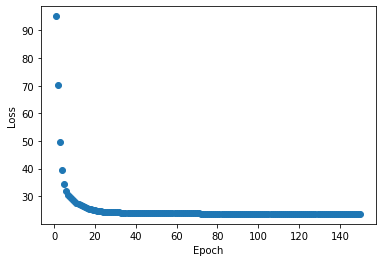

In [ ]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 151)) 

y = loss_df['loss']
x = loss_df['epoch']

plt.scatter(x,y)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# running the model
simple_nn.fit(X_train, y_train, epochs=250, batch_size = 32, validation_data=(X_validation, y_validation))

Epoch 1/250
4103/4103 [==============================] - 12s 3ms/step - loss: 23.6127 - mean_absolute_percentage_error: 23.6127 - val_loss: 22.7442 - val_mean_absolute_percentage_error: 22.7442
Epoch 2/250
4103/4103 [==============================] - 16s 4ms/step - loss: 23.6069 - mean_absolute_percentage_error: 23.6069 - val_loss: 22.7438 - val_mean_absolute_percentage_error: 22.7438
Epoch 3/250
4103/4103 [==============================] - 13s 3ms/step - loss: 23.6100 - mean_absolute_percentage_error: 23.6100 - val_loss: 22.7408 - val_mean_absolute_percentage_error: 22.7408
Epoch 4/250
4103/4103 [==============================] - 10s 2ms/step - loss: 23.6096 - mean_absolute_percentage_error: 23.6096 - val_loss: 22.7431 - val_mean_absolute_percentage_error: 22.7431
Epoch 5/250
4103/4103 [==============================] - 11s 3ms/step - loss: 23.6089 - mean_absolute_percentage_error: 23.6089 - val_loss: 22.7422 - val_mean_absolute_percentage_error: 22.7422
Epoch 6/250
4103/4103 [=======

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

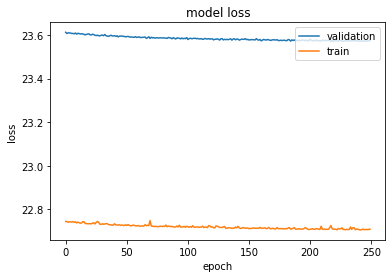

In [ ]:
# see what information has been logged during the training process
plt.plot(simple_nn.history.history['loss'])
plt.plot(simple_nn.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper right')
plt.show()

### Creating the model object and grid search

In [ ]:
# function that creates the model
def create_model(neurons=1):
    nn_model = Sequential()
    nn_model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    nn_model.add(Dense(neurons, activation='relu'))
    nn_model.add(Dense(1))
    nn_model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    return nn_model

seed = 1234
np.random.seed(seed)

model = KerasRegressor(build_fn=create_model, verbose=0, neurons=1)

In [ ]:
# define the grid search parameters
batch_size = [32, 50]
epochs = [100, 150, 250]
neurons = [10, 20, 30]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [ ]:
# showing parameter options
params_grid

{'batch_size': [32, 50], 'epochs': [100, 150, 250], 'neurons': [10, 20, 30]}

In [ ]:
# performing the grid search
start_time = datetime.datetime.now()
grid_search_nn = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1)
grid_search_nn = grid_search_nn.fit(X_train_validation, y_train_validation)
end_time = datetime.datetime.now()
print(f'hypertuning with sklearn grid search for neural networks complete in {round((end_time - start_time).seconds/60, 2)} minutes')

### Selecting the best model and final outcome


In [ ]:
print("The best parameter combination is: {}".format(grid_search_nn.best_params_))

The best parameter combination is: {'batch_size': 32, 'epochs': 250, 'neurons': 30} with score: 0.38487397926401345


In [ ]:
# run the model with the train+validation set, with the best parameters of the grid search
best_model = create_model(30)
best_model.fit(X_train_validation, y_train_validation, epochs=250, batch_size=32, verbose=0)

In [ ]:
#calculating final MAPE score
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['koopPrijs', 'id'],axis=1)
y_test = fitting_splits.test_set['koopPrijs']
y_hat_test_nn = best_model.predict(X_test)
print("The MAPE of the nn model is {}".format(metrics.mean_absolute_percentage_error(y_test, y_hat_test_nn)))

The MAPE of the nn model is 0.23359821134656183


## Conclusion

The goal of this assignment was to develop a machine learning model to predict both sales price and time to sell for housing data from Funda. In this project, two models are used to predict these outcomes: the random forest and neural network model. For both models, the best hyperparameters were searched and applied to determine the final accuracy measure of those models. As an accuracy measure the mean absolute percentage error (MAPE) has been used because it gives a clear number of how accurate it is.

The random forest gave a final MAPE of 24.93% and the neural network model a MAPE of 23.36%. It can therefore be concluded that the neural network model is the best model to predict the house price. The difference, however, is very small (<1%>).
